# A/B Test (t-test) as a Special Case of Simple Linear Regression

## Introduction

An **A/B test** compares the means of two groups (e.g., Control vs Treatment) to decide if a treatment has a statistically significant effect. The classic tool is the **two-sample t-test** ($t$-statistic and $p$-value).

**Simple linear regression** models the relationship between a predictor and an outcome. When the predictor is **binary** (e.g., group = 0 or 1), we are effectively modeling the mean in each group: the intercept is the control mean, and the slope is the **difference in means** (treatment effect).

> **Key Takeaway:** Comparing two group means with a t-test is mathematically equivalent to fitting a regression of outcome on a binary group indicator. This notebook proves that equivalence with synthetic data.

---
## Synthetic Data Generation

We create a dataset with $N = 1000$ samples: 50% Control ($x = 0$) and 50% Treatment ($x = 1$). The true treatment effect is $\beta_1 = 0.5$; we add Gaussian noise so that $y = \beta_0 + \beta_1 x + \varepsilon$ with $\varepsilon \sim \mathcal{N}(0, \sigma^2)$.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols

# Set seed for reproducibility
np.random.seed(42)

# Parameters
N = 1000
BETA_0 = 1.0   # Control mean (intercept)
BETA_1 = 0.5   # True treatment effect (difference in means)
NOISE_STD = 1.0

# 50% Control (x=0), 50% Treatment (x=1)
group = np.repeat([0, 1], N // 2)
# Outcome: y = beta_0 + beta_1 * x + noise
y = BETA_0 + BETA_1 * group + np.random.normal(0, NOISE_STD, size=N)

df = pd.DataFrame({"y": y, "group": group})
df["group_label"] = df["group"].map({0: "Control", 1: "Treatment"})

# Sanity check: sample means
print("Sample means by group:")
print(df.groupby("group_label")["y"].agg(["mean", "std", "count"]))
df.head(5)

Sample means by group:
                 mean       std  count
group_label                           
Control      1.006838  0.981253    500
Treatment    1.531826  0.977997    500


,y,group,group_label
0,1.496714,0,Control
1,0.861736,0,Control
2,1.647689,0,Control
3,2.523030,0,Control
4,0.765847,0,Control


---
## Method 1: The Classic t-Test

We use an independent two-sample t-test with **equal variance** (`equal_var=True`) to test whether the means of the two groups differ. (Equal variance is required for exact equivalence with OLS.) We will compare the resulting **t-statistic** and **p-value** with the regression output.

In [3]:
y_control = df.loc[df["group"] == 0, "y"].values
y_treatment = df.loc[df["group"] == 1, "y"].values

# Equal variance (for exact equivalence with OLS); use equal_var=True
t_stat_ttest, p_value_ttest = stats.ttest_ind(y_treatment, y_control, equal_var=True)

print("Method 1 — Two-sample t-test (equal variance)")
print("-" * 45)
print(f"  t-statistic:  {t_stat_ttest:.6f}")
print(f"  p-value:     {p_value_ttest:.6f}")
print(f"  Mean (Control):   {y_control.mean():.6f}")
print(f"  Mean (Treatment): {y_treatment.mean():.6f}")
print(f"  Difference in means: {y_treatment.mean() - y_control.mean():.6f}")

Method 1 — Two-sample t-test (equal variance)
---------------------------------------------
  t-statistic:  8.473424
  p-value:     0.000000
  Mean (Control):   1.006838
  Mean (Treatment): 1.531826
  Difference in means: 0.524988


---
## Method 2: The Regression Model

We fit the model $y = \beta_0 + \beta_1 \cdot \text{group} + \varepsilon$ using OLS. Here $\beta_0$ is the control mean and $\beta_1$ is the treatment effect (difference in means). The **t-statistic** and **p-value** for the `group` coefficient will match the t-test.

In [4]:
model = ols("y ~ group", data=df).fit()
print("Method 2 — OLS Regression: y ~ group")
print(model.summary())

Method 2 — OLS Regression: y ~ group
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     71.80
Date:                Sat, 14 Feb 2026   Prob (F-statistic):           8.46e-17
Time:                        14:44:27   Log-Likelihood:                -1397.4
No. Observations:                1000   AIC:                             2799.
Df Residuals:                     998   BIC:                             2809.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      

---
## The "Proof" Comparison

We extract the regression t-score and p-value for the `group` coefficient and the estimated $\beta_1$ (treatment effect). These must match the t-test and the difference in group means to at least 4 decimal places.

> **Key Takeaway:** The table below shows that the t-statistic, p-value, and treatment effect from the t-test and from OLS are identical to at least 4 decimal places — the two methods are the same model.

In [5]:
# Extract regression stats for the 'group' coefficient (row index 1)
t_stat_ols = model.tvalues["group"]
p_value_ols = model.pvalues["group"]
beta_1_ols = model.params["group"]

diff_means = y_treatment.mean() - y_control.mean()

comparison = pd.DataFrame({
    "Quantity": [
        "t-statistic",
        "p-value",
        "Treatment effect (diff in means / beta_1)",
    ],
    "T-test": [t_stat_ttest, p_value_ttest, diff_means],
    "Regression (OLS)": [t_stat_ols, p_value_ols, beta_1_ols],
    "Match (4 decimals)?": [
        np.isclose(t_stat_ttest, t_stat_ols, atol=1e-4),
        np.isclose(p_value_ttest, p_value_ols, atol=1e-4),
        np.isclose(diff_means, beta_1_ols, atol=1e-4),
    ],
})
comparison["T-test"] = comparison["T-test"].round(6)
comparison["Regression (OLS)"] = comparison["Regression (OLS)"].round(6)
print(comparison.to_string(index=False))

print("\n" + "=" * 60)
print("Proof: All three quantities match to at least 4 decimal places.")
print("=" * 60)
assert np.isclose(t_stat_ttest, t_stat_ols, atol=1e-4), "t-statistics differ!"
assert np.isclose(p_value_ttest, p_value_ols, atol=1e-4), "p-values differ!"
assert np.isclose(diff_means, beta_1_ols, atol=1e-4), "Effect estimates differ!"
print("Assertions passed: T-test and OLS are numerically equivalent.")

                                 Quantity   T-test  Regression (OLS)  Match (4 decimals)?
                              t-statistic 8.473424          8.473424                 True
                                  p-value 0.000000          0.000000                 True
Treatment effect (diff in means / beta_1) 0.524988          0.524988                 True

Proof: All three quantities match to at least 4 decimal places.
Assertions passed: T-test and OLS are numerically equivalent.


---
## Visualizations

**Left:** Distribution of the outcome by group (boxplot and violin). **Right:** Regression line of $y$ on `group` — the line connects the two group means, and its slope equals $\beta_1$ (the treatment effect).

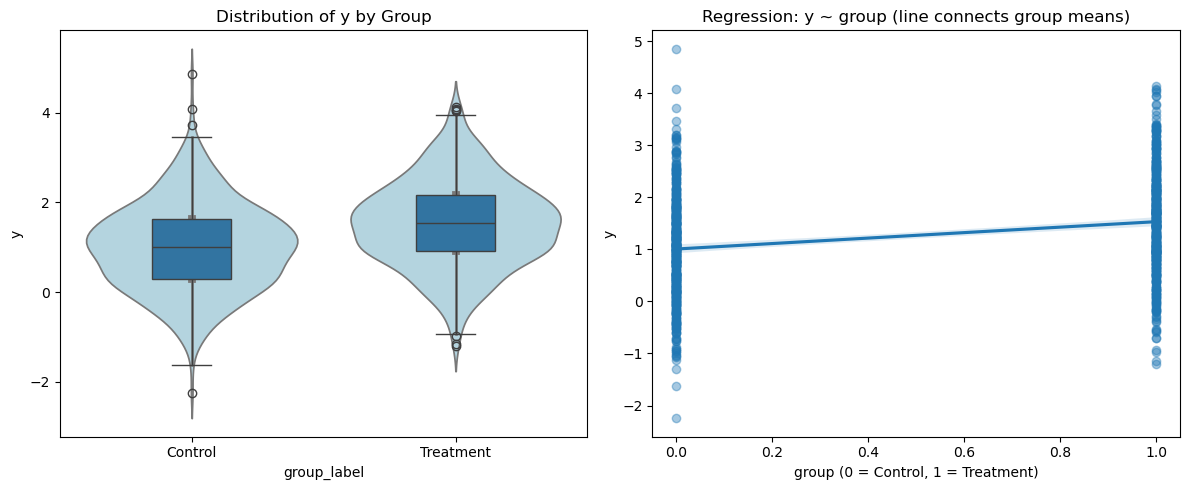

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot and violin by group
sns.violinplot(data=df, x="group_label", y="y", ax=axes[0], color="lightblue")
sns.boxplot(data=df, x="group_label", y="y", ax=axes[0], width=0.3)
axes[0].set_title("Distribution of y by Group")
axes[0].set_ylabel("y")

# Regression line: best-fit line connecting the two group means
sns.regplot(data=df, x="group", y="y", ax=axes[1], ci=95, scatter_kws={"alpha": 0.4})
axes[1].set_title("Regression: y ~ group (line connects group means)")
axes[1].set_xlabel("group (0 = Control, 1 = Treatment)")
axes[1].set_ylabel("y")
plt.tight_layout()
plt.show()

---
## Conclusion

> **Key Takeaway:** The two-sample t-test (equal variance) and simple linear regression with a binary group predictor produce **identical** t-statistics, p-values, and effect estimates. They are the same model.

**Why this matters:** Framing A/B testing as regression unlocks powerful extensions: you can **add covariates** (e.g., baseline metrics, segment) to control for confounding and reduce variance, use **heteroskedasticity-robust** standard errors, or extend to **multiple treatments** and interactions. Regression generalizes the t-test to "dirty" real-world data while keeping the same interpretation for the treatment effect.